In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
# from itertools import product
# from collections import defaultdict
# from tqdm import tqdm

# %matplotlib widget
plt.rcParams['text.usetex'] = True

In [3]:
adj = pd.read_csv(r"D:\IMSc coursework\PopEcoEvo\ECOPATH II Files\Galapagos, Floreana rocky reef-Diet composition.csv")

In [4]:
adj2 = adj.replace(np.nan, 0)
adj3 = (adj2 != 0).astype(int)
adj_unw = adj3.iloc[1:39, 2:40]
adj_unw.index = adj_unw.columns

In [5]:
g = nx.from_pandas_adjacency(adj_unw, create_using=nx.DiGraph)


# Basic Statistics

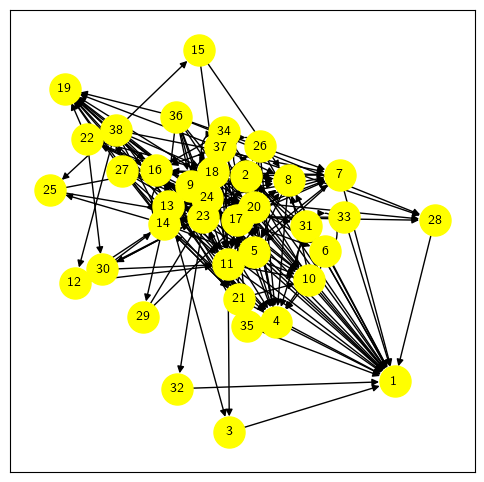

In [31]:
plt.figure(figsize=(6,6))
nx.draw_networkx(g, with_labels=True,  node_color="yellow", node_size=500, font_size=10)
plt.show()


## Adjacency Matrix of Unweighted Graph

([], [])

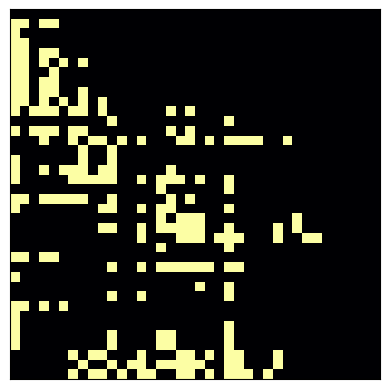

In [10]:
plt.imshow(adj_unw.to_numpy(), cmap='inferno', origin='upper')
plt.xticks([])
plt.yticks([])


In [13]:
print(f'#Nodes = {len(g.nodes)}')
print(f'#Edges = {len(g.edges)}')
print(f'#Self-loops = {nx.number_of_selfloops(g)}')

#Nodes = 38
#Edges = 211
#Self-loops = 9


In [14]:
in_degrees = [d for n, d in g.in_degree()]
out_degrees = [d for n, d in g.out_degree()]

print(f'<in-degree> = {np.mean(in_degrees)}')
print(f'<out-degree> = {np.mean(out_degrees)}')

<in-degree> = 5.552631578947368
<out-degree> = 5.552631578947368


Text(0.5, 1.0, 'Out-degree Distribution')

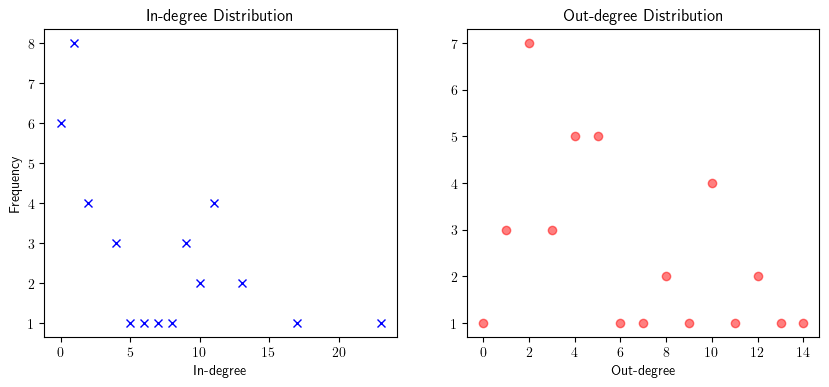

In [16]:
indg, indg_counts = np.unique(np.array(in_degrees), return_counts=True)
outdg, outdg_counts = np.unique(np.array(out_degrees), return_counts=True)

degreedist, axd = plt.subplots(1, 2, figsize=(10, 4))
# plt.figure(figsize=(4, 4))
axd[0].plot(indg, indg_counts,'x', color='blue', alpha=1)
# axd[0].set_yscale('log')  
axd[0].set_xlabel("In-degree")
axd[0].set_ylabel("Frequency")
axd[0].set_title("In-degree Distribution")

axd[1].plot(outdg, outdg_counts,'o', color='red', alpha=0.5)
# axd[1].set_yscale('log')  
axd[1].set_xlabel("Out-degree")
axd[1].set_title("Out-degree Distribution")

# Motif Search

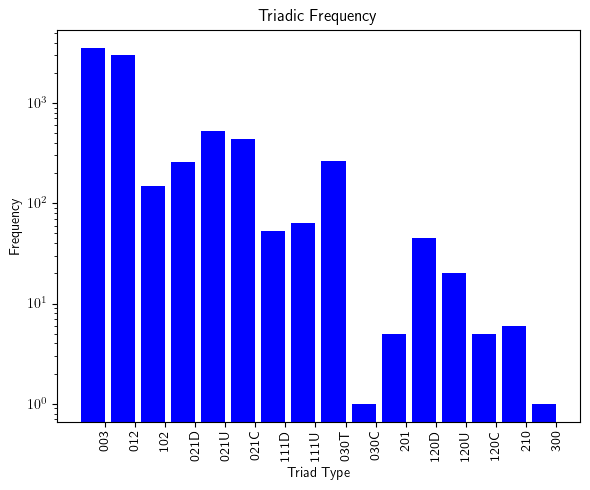

In [6]:
triadic_census = nx.triadic_census(g)
# print(triadic_census)


fig, ax = plt.subplots(figsize=(6, 5))
x_positions = range(len(triadic_census))
bar_width = 0.8  
ax.bar(x_positions, triadic_census.values(), tick_label=triadic_census.keys(), color='blue', width=bar_width)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Triad Type')
plt.title('Triadic Frequency')
ax.set_xticks([x + bar_width / 2 for x in x_positions]) 
ax.set_xticklabels(triadic_census.keys(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

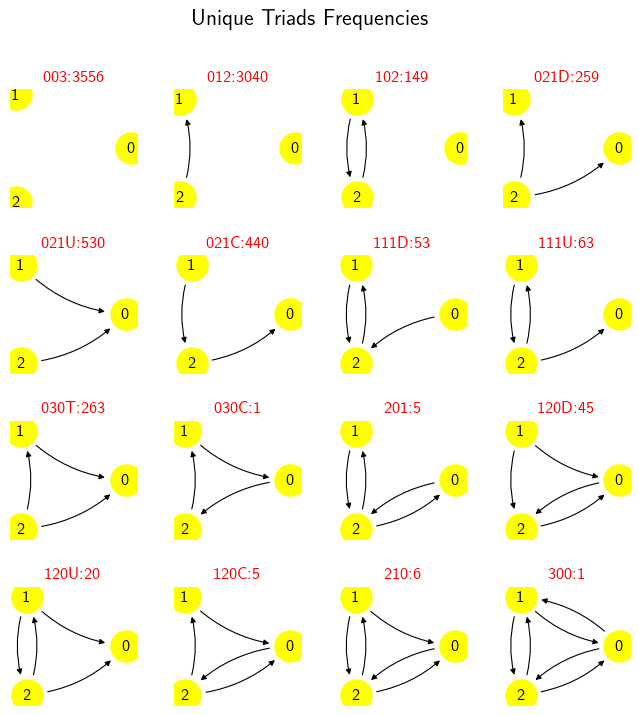

In [ ]:
TRIAD_NAMES = [
    '003', '012', '102', '021D', '021U', '021C', '111D',
    '111U', '030T', '030C', '201', '120D', '120U', '120C',
    '210', '300'
]

nodes = [0, 1, 2]
edges = [(i, j) for i in nodes for j in nodes if i != j] #selfloops excluded. 
edge_combinations = list(product([0, 1], repeat=len(edges)))

unique_graphs = {}
for bits in edge_combinations:
    g = nx.DiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from([e for b, e in zip(bits, edges) if b])
    if len(g.nodes) == 3:
        census = nx.triadic_census(g)
        for name in TRIAD_NAMES:
            if census[name] == 1 and name not in unique_graphs:
                unique_graphs[name] = g
                break

fig, axl = plt.subplots(4, 4, figsize=(8,8))
axl = axl.flatten()
for i, name in enumerate(TRIAD_NAMES):
    g = unique_graphs[name] 
    ax = axl[i]
    ax.set_axis_off()
    ax.set_title(f'{name}:{triadic_census[name]}', fontsize=12, color='red')
    pos = nx.circular_layout(g)
    nx.draw_networkx_nodes(g, pos, ax=ax, node_color='yellow', node_size=500)
    nx.draw_networkx_labels(g, pos, ax=ax)
    nx.draw_networkx_edges(
        g, pos, ax=ax, arrows=True, connectionstyle='arc3,rad=0.2',
        arrowstyle='-|>', min_target_margin=15, min_source_margin=15,
        arrowsize=8, edge_color='black', width=.8, alpha=1
    )
fig.suptitle('Unique Triads Frequencies', fontsize=16, color='black')
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig('triads.png', dpi=450, bbox_inches='tight')
plt.show()


In [ ]:
def triad_motifs_search(g, n_rand_graphs):
    
    n = g.number_of_nodes()
    m = g.number_of_edges()
    p = m / (n * (n - 1))  

    real_census = nx.triadic_census(g)
    triad_types = list(real_census.keys())
    random_censuses = defaultdict(list)

    for _ in tqdm(range(n_rand_graphs), desc="Generating ER graphs"):
        g_er = nx.gnp_random_graph(n, p, directed=True)
        rc = nx.triadic_census(g_er)
        for triad in triad_types:
            random_censuses[triad].append(rc[triad])

    motif_scores = {}
    for triad in triad_types:
        real = real_census[triad]
        rand_vals = random_censuses[triad]
        mean = np.mean(rand_vals)
        std = np.std(rand_vals)
        z = (real - mean) / std if std > 0 else 0.0
        motif_scores[triad] = {
            'real_count': real,
            'random_mean': mean,
            'random_std': std,
            'z_score': z
        }

    return motif_scores


motifs = triad_motifs_search(g, n_rand_graphs=100)
motif_df = pd.DataFrame(motifs).T.sort_values("z_score", ascending=False)

print('Motifs in their descending order of z-score:')
display(motif_df.style.background_gradient(cmap='coolwarm', subset=["z_score"]))


Generating ER graphs: 100%|██████████| 100/100 [00:00<00:00, 16672.51it/s]

Motifs in their descending order of z-score:


,real_count,random_mean,random_std,z_score
003,0.000000,0.000000,0.000000,0.000000
012,0.000000,0.000000,0.000000,0.000000
102,0.000000,0.000000,0.000000,0.000000
021D,0.000000,0.000000,0.000000,0.000000
021U,0.000000,0.000000,0.000000,0.000000
021C,0.000000,0.000000,0.000000,0.000000
111D,0.000000,0.000000,0.000000,0.000000
111U,0.000000,0.000000,0.000000,0.000000
030T,0.000000,0.000000,0.000000,0.000000
030C,0.000000,0.000000,0.000000,0.000000
